# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [3]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [4]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results')

In [5]:
ls $result_base

RNNFilter_20180207_1121/  gnnsegclf_small_000/  resepnn_big_001/
agnn_000/                 gnnsegclf_small_001/  resepnn_big_003/
agnn_001/                 gnnsegclf_small_002/  resmpnn_001/
agnn_002/                 gnnsparse_big_001/    resmpnn_002/
agnn_002_8gpu/            gnnsparse_med_001/    resmpnn_002a/
agnn_003/                 hello/                resmpnn_002b/
agnn_big_000/             mpnn_001/             resmpnn_002c/
agnn_big_001/             mpnn_002/             resmpnn_002d/
agnn_big_002/             mpnn_batch/           resmpnn_003/
agnn_scaling/             mpnn_big_000/         resmpnn_big_000/
gnnsegclf_000/            mpnn_big_001/         resmpnn_big_001/
gnnsegclf_001/            mpnn_big_002/         resmpnn_big_002/
gnnsegclf_004/            mpnn_big_003/         resmpnn_big_003/
gnnsegclf_big_000/        mpnn_big_004/         resmpnn_filt/
gnnsegclf_big_002/        mpnn_big_005/         resmpnn_nomom/
gnnsegclf_big_003/        mpnn_big_006/         resmpn

In [6]:
result_name = 'resmpnn_001'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_000',
          'n_train': 49152,
          'n_valid': 4096,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 5},
 'model': {'hidden_edge_dim': 64,
           'hidden_node_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'resmpnn'},
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 32,
                                      'factor': 0.1,
                                      'start_epoch': 16},
                                     {'end_epoch': 64,
                                      'factor': 0.01,
                                      'start_epoch': 32}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 'output_dir'

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.200717,0,2466.645094,0.125323,0.950963,104.503976
1,0.00100,0.106754,1,2463.484914,0.091496,0.967420,104.242031
2,0.00100,0.186337,2,2463.307323,0.182884,0.918509,103.998863
3,0.00100,0.124927,3,2463.742164,0.094012,0.965148,104.362589
4,0.00100,0.093549,4,2461.907552,0.092987,0.967284,104.110224
...,...,...,...,...,...,...,...
59,0.00001,0.037419,59,2461.633243,0.029102,0.992183,103.747491
60,0.00001,0.037413,60,2462.951930,0.030422,0.991947,104.094949
61,0.00001,0.037415,61,2462.305425,0.029894,0.992032,103.857074
62,0.00001,0.037418,62,2589.870159,0.029029,0.992307,103.073277


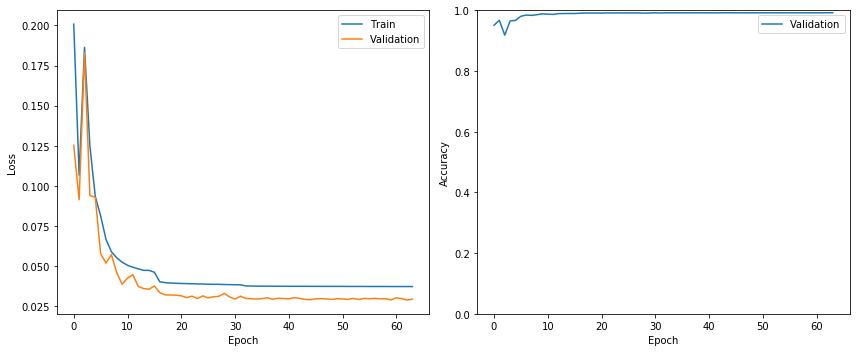

In [7]:
plot_train_history(summaries)

## Load the trained model

In [8]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
62,0.00001,0.037418,62,2589.870159,0.029029,0.992307,103.073277


In [9]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bia

## Load the test data set and evaluate the model

In [10]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [11]:
%%time
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 34s, sys: 5.07 s, total: 1min 39s
Wall time: 24.9 s


In [12]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9925
Precision: 0.9254
Recall:    0.9744


In [13]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9953
Precision: 0.9722
Recall:    0.9620


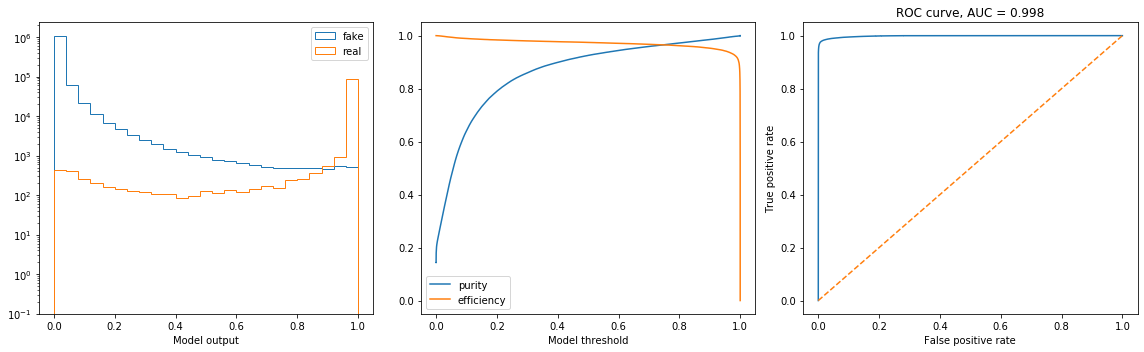

In [14]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [15]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [16]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

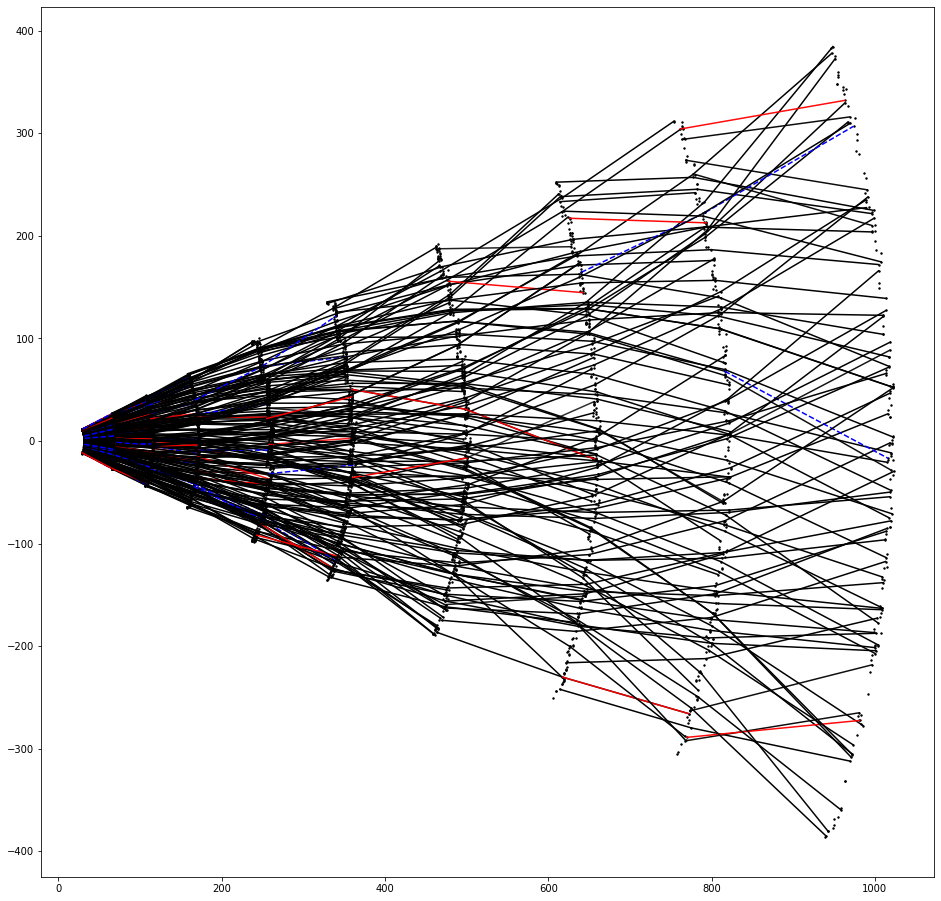

In [17]:
draw_sample_xy(x, e, o, y, cut=0.8);